# Оператор связи «Ниединогоразрыва.ком»

**Описание**

Оператор связи `«Ниединогоразрыва.ком»` хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Данные**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Цель**

Обучить модель, которая будет прогнозировать отток клиентов, что со стороны заказчика поможет удерживать клиентскую базу и преумножить доход.

**Задачи**

1. Загрузка и изучение данных.
* проверить соответствие типам данных
* проверить наличие пропусков и дубликатов
* проверить регистр столбцов

2. Подготовка данных
* определить значащие признаки и составить целевой признак
* соединить таблицы по полю `customerID`

3. Исследовательский анализ данных.
* построить графики распределения данных
* выявить аномальные значения в данных

5. Предобработка данных.
* устранить пропуски и аномалии
* исследовать признаки на мультиколлинеарность
* выявить дисбаланс классов

6. Подготовка данных к обучению.
* разделить данные на обучающую и тестовую выборки
* закодировать данные и выполнить стандартизацию

7. Обучение модели.
* подготовить и обучить модели, перебрав разные гиперпараметры
* определить наилучшую модель

8. Проверка модели
* протестирвать наилучшую модель на тестовой выборке
* проанализировать матрицу ошибок

9. Анализ важности признаков.

10. Вывод.

## Загрузка и изучение данных

Подключим необходимые библиотеки.

In [29]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import phik

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)


from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, \
    roc_auc_score, \
    accuracy_score



from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 12

 Загрузим все предоставленные данные:
 
 * data_contract — информация о договоре
 * data_personal — персональные данные клиента
 * data_internet — информация об интернет-услугах
 * data_phone — информация об услугах телефонии
 
 Информация о столбцах:
 
* BeginDate – дата начала пользования услугами
* EndDate – дата окончания пользования услугами
* Type – тип оплаты: ежемесячный, годовой и тд
* PaperlessBilling – электронный платёжный документ
* PaymentMethod – способ оплаты
* MonthlyCharges – ежемесячные траты на услуги по договору
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [30]:
try:
    data_contract = pd.read_csv('data/contract_new.csv')
    data_personal = pd.read_csv('data/personal_new.csv')
    data_internet = pd.read_csv('data/internet_new.csv')
    data_phone = pd.read_csv('data/phone_new.csv')
except Exception:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

Выведем полученные таблицы, типы данных и общую информацию.

In [31]:
def display_data(data, name: str):
    print(f'Файл: {name}')
    display(data)
    print(f'\nТипы данных:\n\n{data.dtypes}',
          data.info(), 
          f'\n\nКоличеcтво дубликатов: {data.duplicated().sum()}\n')

In [32]:
tables = [data_contract, data_personal, data_internet, data_phone]
tables_name = ['Информация о договоре', 
               'Персональные данные клиента', 
              'Информация об интернет-услугах', 
              'информация об услугах телефонии']

for data, name in zip(tables, tables_name): 
    display_data(data, name)
    print('+---------------------------------------------------------+\n')

Файл: Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Типы данных:

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object None 

Количеcтво дубликатов: 0

+---------------------------------------------------------+

Файл: Персональные данн

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Типы данных:

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object None 

Количеcтво дубликатов: 0

+---------------------------------------------------------+

Файл: Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Типы данных:

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object None 

Количеcтво дубликатов: 0

+---------------------------------------------------------+

Файл: информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Типы данных:

customerID       object
MultipleLines    object
dtype: object None 

Количеcтво дубликатов: 0

+---------------------------------------------------------+



**Общий вывод:** 


* данные загружены корректно
* столбцы необходимо привести к нижнему регистру, чтобы в будущем было удобнее обращаться к данным
* дубликаты отсутсвуют 
* пропуски отсутсвуют
* тип данных столбца `TotalCharges` таблицы `data_contract` необбходимо привести к типу `float`

Исправим найденные проблемы в данных.

Приведем все столбцы к нижнему регистру.

In [33]:
def low_col(column_el):
    return str.lower('_'.join(re.sub(r"([A-Z])", r" \1", column_el).split()))

In [34]:
data_contract.columns = map(low_col, data_contract.columns)
data_internet.columns = map(low_col, data_internet.columns)
data_phone.columns = map(low_col, data_phone.columns)
data_personal.columns = map(low_col, data_personal.columns)

При попытке изменения типа данных в столбце `totalcharges` были найдены неявные пропуски, а точнее пустые строки. Следовательно, необходимо заполнить эти пропуски значением Nan.

Теперь можем менять тип данных.

In [35]:
data_contract.total_charges = pd.to_numeric(data_contract.total_charges, errors = 'coerce')

## Подготовка данных

Соединим таблицы.

In [36]:
data_full = data_personal.merge(data_contract, how = 'left', on = 'customer_i_d')\
    .merge(data_internet, how = 'left', on = 'customer_i_d').\
    merge(data_phone, how = 'left', on = 'customer_i_d')

data_full

,customer_i_d,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,Fiber optic,No,No,No,No,No,No,Yes


Создадим целевой признак, целевым признаком будем считать столбец `is_client`:

* **1** - если в столбце присутствует дата
* **0** - даты нет

In [37]:
data_full['end_date'] = data_full['end_date'].replace('No', '2020-02-01')

Создадим новый признак `duration_time_days` — срок пользования услугами в днях. В столбце `end_date` в значениях `No` поставим дату `2020-01-02`, так как это дата выгрузки данных.

In [38]:
data_full['is_client'] = data_full['end_date'].apply(lambda x: 1 if x != '2020-02-01' else 0)

Теперь создадим новый признак.

In [39]:
data_full[['end_date', 'begin_date']] = data_full[['end_date', 'begin_date']].astype("datetime64[ns]")
data_full['duration_time_days'] = (data_full.end_date - data_full.begin_date).dt.days

Выделим незначащие столбцы:

* `customer_id` — id не будет давать существенного влияния при обучении.
* `gender` — пол не будет давать существенного влияния при обучении.
* `begindate` — дата заключения договора не будет давать существенного влияния при обучении.
* `end_date` — дата заключения договора не будет давать существенного влияния при обучении.

Удалим эти столбцы.

In [40]:
data_full = data_full.drop(['customer_i_d', 'gender', 'begin_date', 'end_date'], axis = 1)

## Исследовательский анализ данных

Построим распределение категориальных признаков.

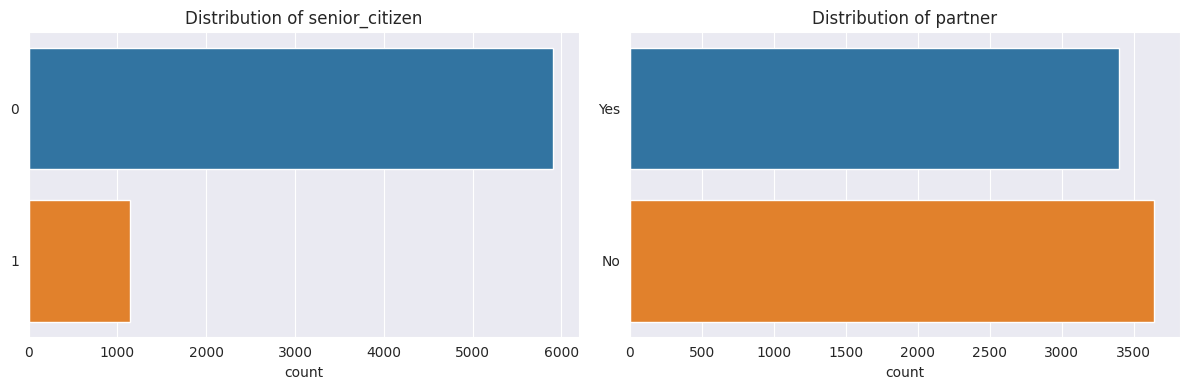

+------------------------------------------------------------------------------------------------------------------------------------+



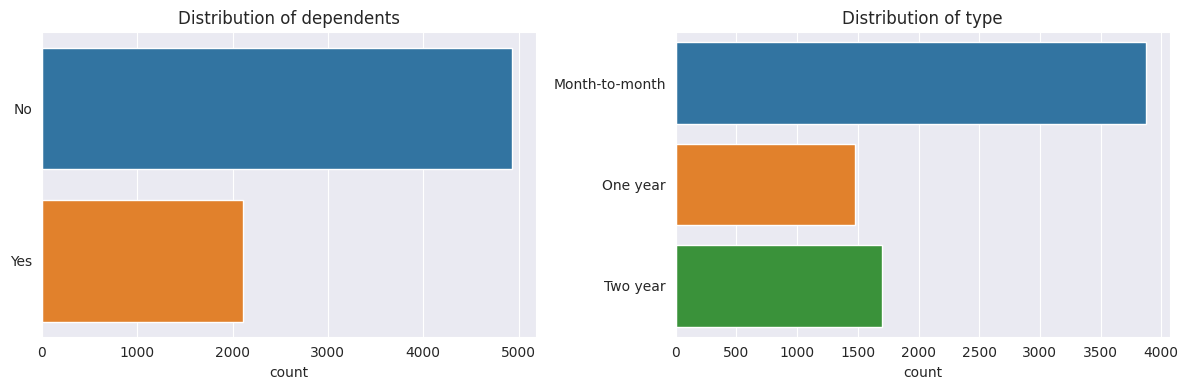

+------------------------------------------------------------------------------------------------------------------------------------+



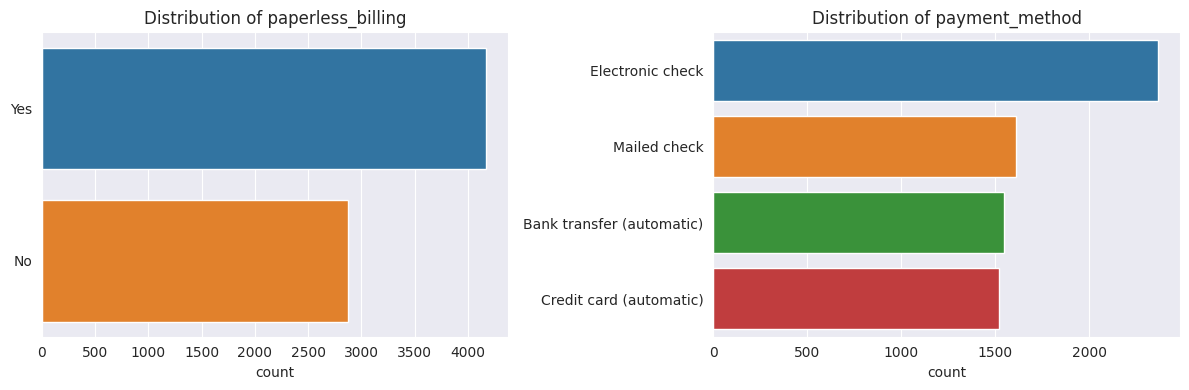

+------------------------------------------------------------------------------------------------------------------------------------+



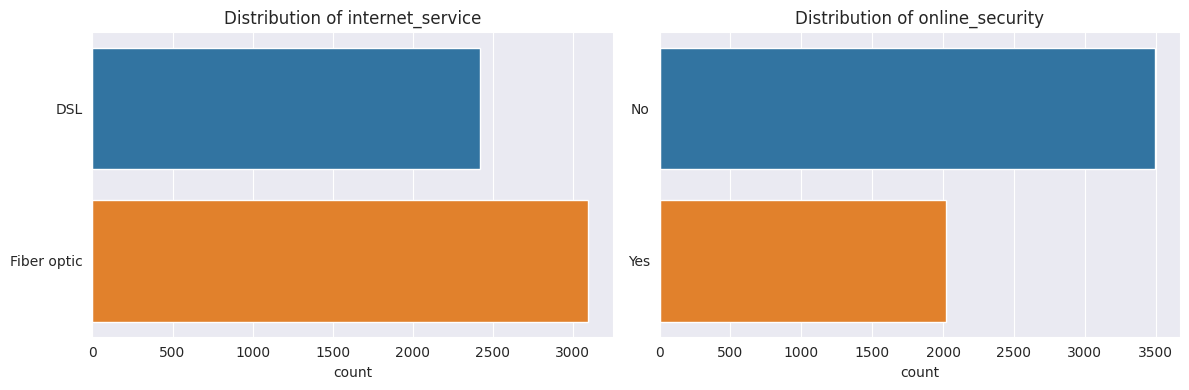

+------------------------------------------------------------------------------------------------------------------------------------+



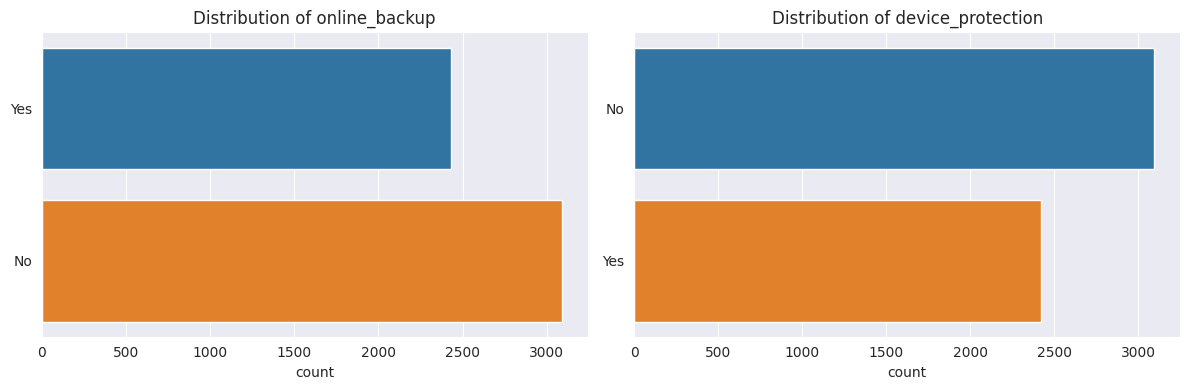

+------------------------------------------------------------------------------------------------------------------------------------+



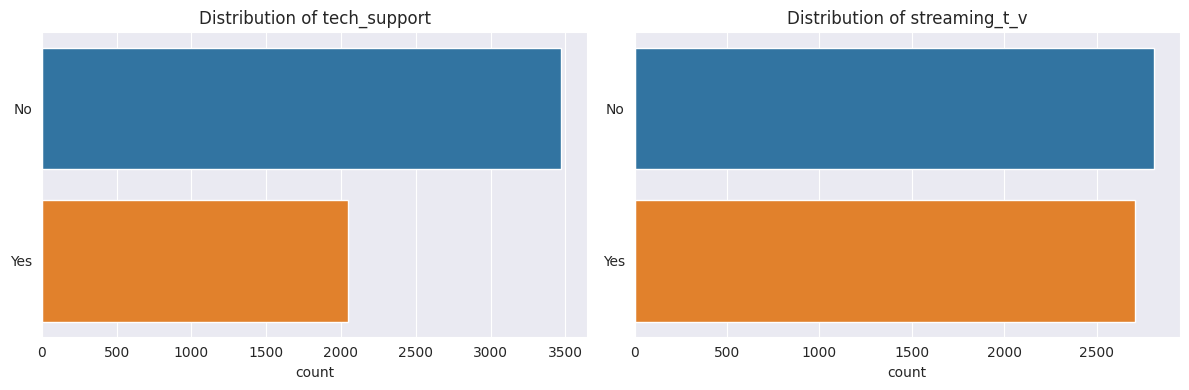

+------------------------------------------------------------------------------------------------------------------------------------+



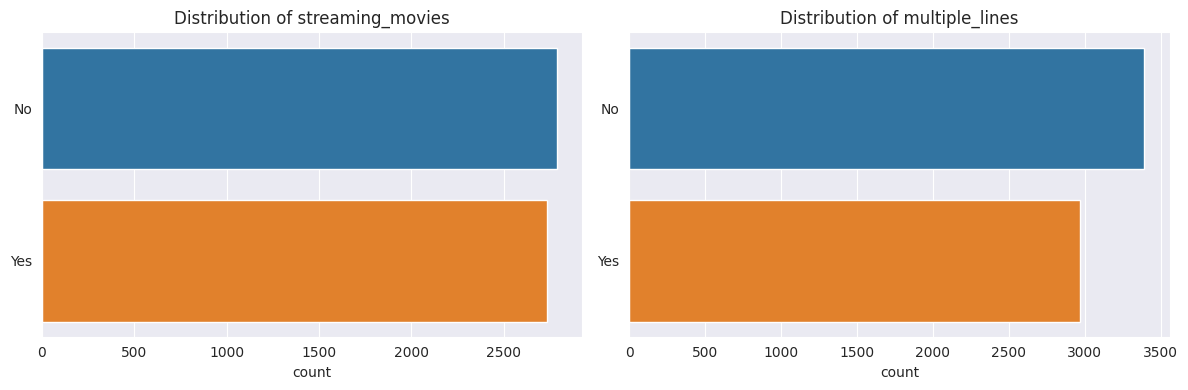

+------------------------------------------------------------------------------------------------------------------------------------+



In [41]:
cat_col = list(filter(lambda a: a not in ['monthly_charges',
                                          'total_charges',
                                          'duration_time_days'] , data_full.columns))

for i in range(0, len(cat_col)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_title(f'Distribution of {cat_col[i]}')
    ax[1].set_title(f'Distribution of {cat_col[i+1]}')

    sns.countplot(data = data_full, y = data_full[cat_col[i]], ax=ax[0])
    sns.countplot(data = data_full, y = data_full[cat_col[i+1]], ax=ax[1])

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    fig.tight_layout()


    plt.show()
    print('+------------------------------------------------------------------------------------------------------------------------------------+\n')

Построим распределение численных признаков.

       monthly_charges  total_charges  duration_time_days
count      7043.000000    7032.000000         7043.000000
mean         64.761692    2118.621822          898.555729
std          30.090047    2112.736199          683.130510
min          18.250000      19.050000            0.000000
25%          35.500000     439.745000          276.000000
50%          70.350000    1345.275000          761.000000
75%          89.850000    3239.317500         1461.000000
max         118.750000    9221.380000         2314.000000


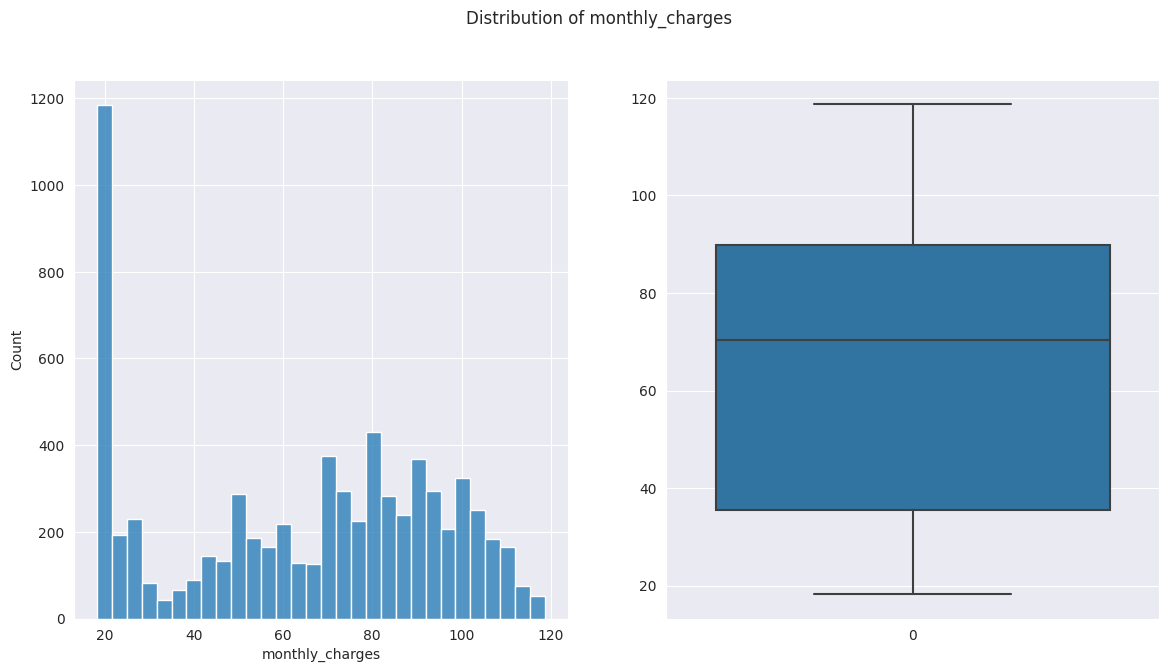

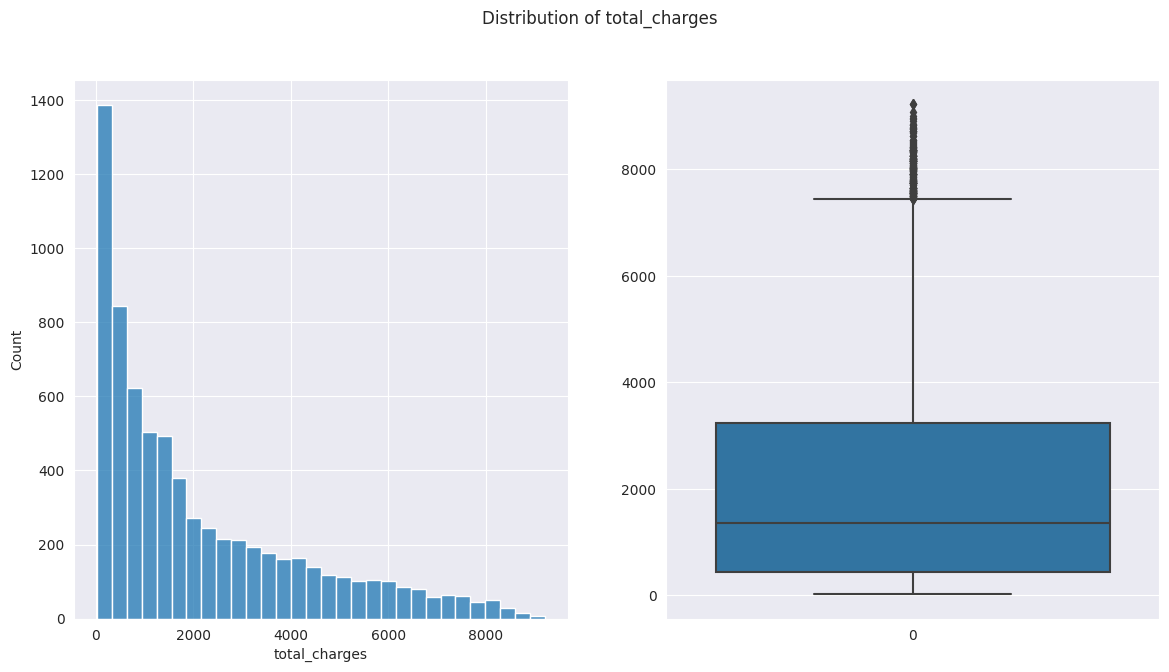

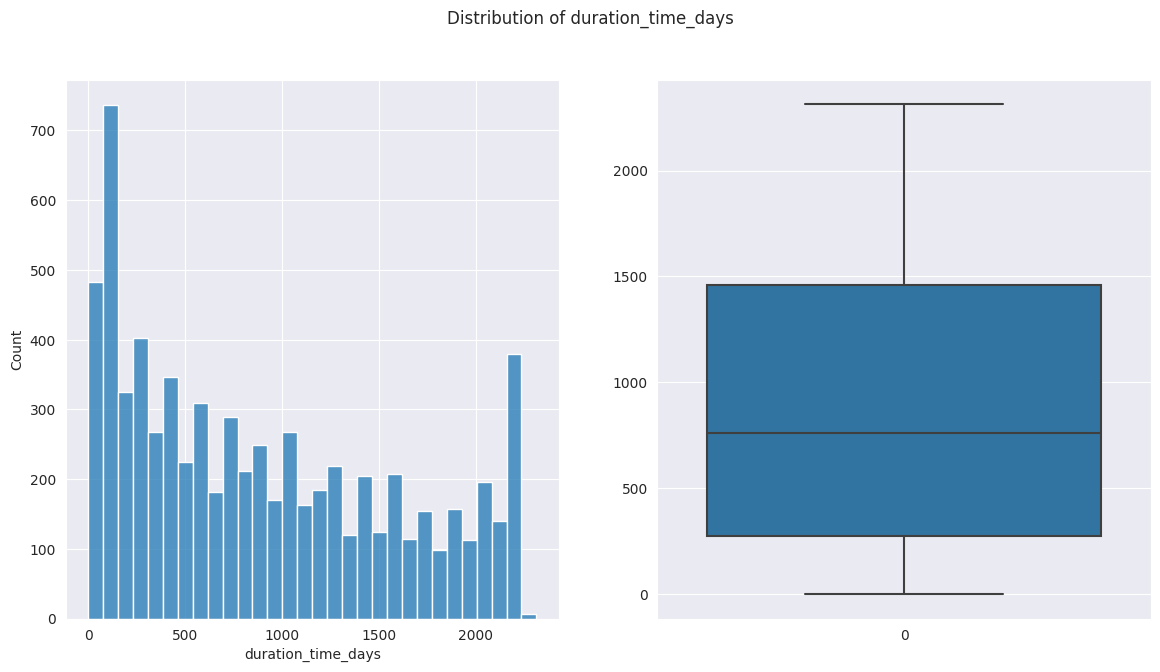

In [42]:
def hist_and_boxplot(data, column):
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    sns.histplot(data[column], bins = 30, ax = ax[0])
    sns.boxplot(data[column], ax = ax[1])
    fig.suptitle(f'Distribution of {column}', size = 12)
    plt.show()


print(data_full[['monthly_charges', 'total_charges', 'duration_time_days']].describe())
for column in ['monthly_charges',
               'total_charges',
               'duration_time_days']:
    hist_and_boxplot(data_full, column)

**Вывод:**

Категориальные признаки:

* аномальные значения отсутствуют
* `senior_citizen` — преобладает отсутствие пенсионного статуса по возрасту
* `dependents` — преобладает отсутствие иждивенца
* `end_date` — преобладают пользователи, которые не покинули сервис
* `type` — преобладает тип подписки `Month-to-Month`
* `online_security` — преобладает отсутствие онлайн защиты

Численные признаки:

* аномальные значения отсутствуют
* присутствуют сильные пики у значения `0`

## Предобработка данных

Выведем количество пропусков в процентном соотношении.

In [43]:
def plot_null():
    null_values = round(data_full.isna().sum().sort_values(ascending = False) / data_full.shape[0], 4)
    sns.barplot(y = null_values.index, x = null_values.values)
    print(null_values)

online_security       0.2167
online_backup         0.2167
streaming_movies      0.2167
streaming_t_v         0.2167
tech_support          0.2167
internet_service      0.2167
device_protection     0.2167
multiple_lines        0.0968
total_charges         0.0016
is_client             0.0000
senior_citizen        0.0000
partner               0.0000
monthly_charges       0.0000
payment_method        0.0000
paperless_billing     0.0000
type                  0.0000
dependents            0.0000
duration_time_days    0.0000
dtype: float64


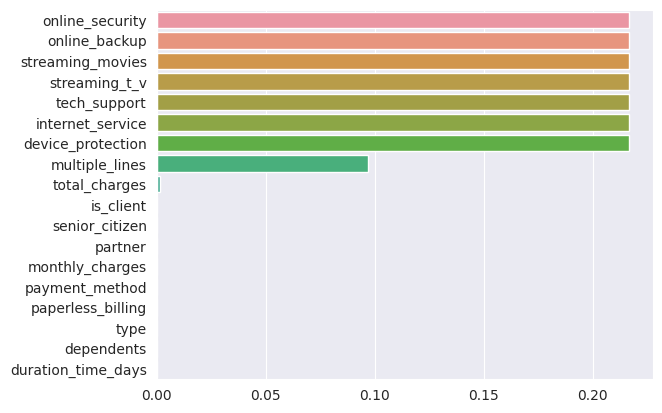

In [44]:
plot_null()

Видно, что в данных из таблицы `data_phone` (информация об услугах телефонии) присутствует много пропусков. Следовательно, либо данные некоторых клиентов не внесены в базу, либо у клиента попросту нет данных функций. Так как процент данных слишком велик, возможности удалить данные нет, поэтому заполним пропуски отрицательными значениями. Пропуски в значениях столбца `multiple_lines` можем заполнить по тому же принципу.


Пропусков в значениях столбца `total_charges` говорят о том, что пользователь еще не усаел совершить покупки, поэтому заполним значением 0.

In [45]:
data_full.iloc[ : , 8:17 ] = data_full.iloc[ : , 8:17 ].fillna('No')
data_full.fillna(0, inplace=True)

Проверим оставшиеся пропуски.

senior_citizen        0.0
partner               0.0
is_client             0.0
multiple_lines        0.0
streaming_movies      0.0
streaming_t_v         0.0
tech_support          0.0
device_protection     0.0
online_backup         0.0
online_security       0.0
internet_service      0.0
total_charges         0.0
monthly_charges       0.0
payment_method        0.0
paperless_billing     0.0
type                  0.0
dependents            0.0
duration_time_days    0.0
dtype: float64


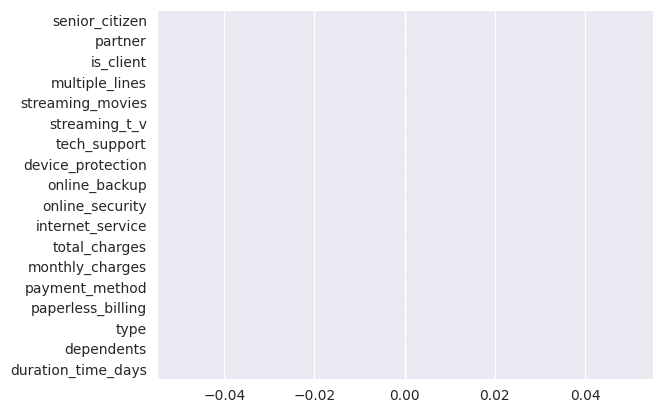

In [46]:
plot_null()

Пропусков больше нет!

Необходимо проверить неявные пропуски, но из пункта `Исследовательский анализ данных` можно сделать вывод, что они отсутствуют.

Исследуем признаки на мультиколлинеарность.

In [47]:
interval_columns = ['monthly_charges',
                    'total_charges',
                    'duration_time_days']

corr = data_full.phik_matrix(interval_cols = interval_columns)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')
 .format(precision=2))

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,is_client,duration_time_days
senior_citizen,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
partner,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dependents,0.32,0.65,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
type,0.09,0.18,0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
paperless_billing,0.24,0.01,0.17,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
payment_method,0.29,0.24,0.22,0.28,0.37,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
monthly_charges,0.30,0.20,0.18,0.39,0.47,0.40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
total_charges,0.14,0.38,0.08,0.47,0.20,0.34,0.71,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
internet_service,0.16,0.00,0.11,0.51,0.23,0.32,0.92,0.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
online_security,0.06,0.22,0.12,0.15,0.00,0.26,0.55,0.52,0.24,nan,nan,nan,nan,nan,nan,nan,nan,nan


Возьмем пороговое значение корреляции — `0.8`. Тогда можно сделать вывод, что:

* столбцы `internet_service`,  `streaming_t_v`, `streaming_movies` сильно коррелируют с признаком `monthly_charges`, поэтому их необходимо удалить
* столбец `total_charges` сильно коррелирует со столбцом `duration_time_days`, поэтому удалим столбец `total_charges`

In [48]:
data_full = data_full.drop(['internet_service',  'streaming_t_v', 'streaming_movies', 'total_charges'], axis = 1)

Проверим целевой признак на дисбаланс классов.

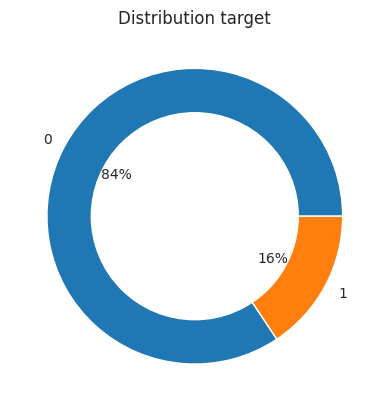

In [49]:
plt.pie(data_full.is_client.value_counts(), labels = ['0', '1'], autopct='%1.0f%%')

my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Distribution target')

plt.show()

Дисбаланс классов присутствует.

**Вывод:**

* устранены пропуски и аномалии
* проведено исследование признаков на мултколлениарность, что позволило избавиться от лишних столбцов
* выявлен дисбаланс классов, поэтому будем использовать метрику качества `AUC-ROC`, которая нечувствительна к дисбалансу



## Подготовка данных к обучению.

Разделим данные на обучающую и тестовую выборки.

In [50]:
features = data_full.drop(['is_client'], axis=1)
target = data_full['is_client']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_STATE, stratify=target
)

Начнем кодирование данных. Кодирование будем выполнять с помощью OrdinalEncoder.

In [51]:
features_train.senior_citizen = features_train.senior_citizen.astype('object')

ohe_features = features_train.select_dtypes(include='object').columns.to_list()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

## Обучение модели

Обучим разные модели.

Простые модели:

* DecisionTreeClassifier
* RandomForestClassifier

Модели на основе градиентного бустинга:

* CatBoostClassifier

Подготовим пайплайн для обучения моделей.

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # количественные признаки
        ('cat', OneHotEncoder(), ohe_features)  # категориальные признаки
    ])

pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', None)
]
)


param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'model__C': np.logspace(-3,3,20),
        'model__penalty': ["l1", "l2"]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__criterion': ['gini','entropy'],
        'model__max_depth': range(1, 6)
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': range(10, 101, 30),
        'model__max_depth': range(1, 6)
    },
    {
        'model': [cb.CatBoostClassifier(random_state=RANDOM_STATE)],
        'model__learning_rate': [0.01, 0.03, 0.001],
        'model__depth': range(1, 6)
    }
]

Создадим модели, и подберем параметры с помощью GridSearchCV.

In [53]:
def get_results(model, name):
    print(f''
          f'Модель {name}:\n' \
           f'Параметры: {model.best_params_}\n' \
           f'ROC-AUC: {model.best_score_}')

In [54]:
interaction_only=True

In [67]:
grid_pipe = GridSearchCV(pipeline,
                         param_grid,
                         cv = 3,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose= False)
grid_pipe.fit(features_train, target_train)

In [66]:
get_results(grid_pipe, 'CatBoostClassifier')

Модель CatBoostClassifier:
Параметры: {'model': <catboost.core.CatBoostClassifier object at 0x7fd0dd10c850>, 'model__depth': 5, 'model__learning_rate': 0.03}
ROC-AUC: 0.896539501098553


**Вывод:**

Видно, что лучше всех себя показала модель **CatBoostClassifier** с параметрами `{'depth': 5, 'learning_rate': 0.03}` и ROC-AUC: `0.90`.

## Проверка модели

Проверим наилучшую модель на тестовой выборке.

In [56]:
model_best = cb.CatBoostClassifier(random_state=RANDOM_STATE, depth= 5,  learning_rate = 0.03, cat_features=ohe_features, verbose = False)
model_best.fit(features_train, target_train)

print(f'Acc: {accuracy_score(model_best.predict(features_test), target_test)}')
print(f'ROC-AUC: {roc_auc_score(target_test, model_best.predict_proba(features_test)[:, 1])}')

Acc: 0.9070262597586941
ROC-AUC: 0.9196612890893799


Проанализируем матрицу ошибок.

In [57]:
def plot_conf_matr(model_best, f_test, t_test):
    predictions = model_best.predict(f_test)
    print(f'Количество записей: {t_test.shape[0]}\n')

    cf_matrix = confusion_matrix(predictions, t_test)

    ax = sns.heatmap(cf_matrix, annot= True , fmt="d",  cmap='Blues')

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');


    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

Количество записей: 1409



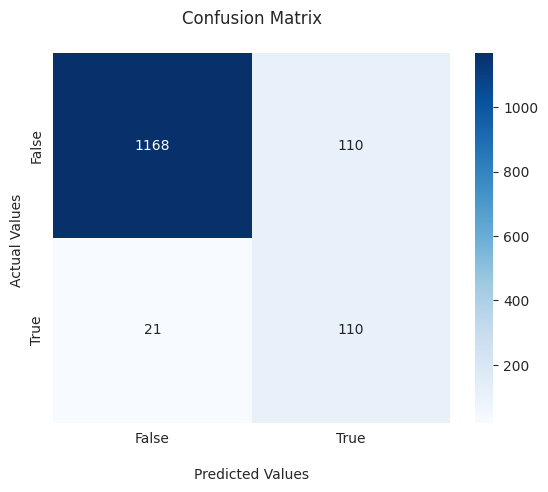

In [58]:
plot_conf_matr(model_best, features_test, target_test)

**Вывод:**

* Значение `accuracy` и `roc-auc` на тестовой выборке: **0.90** и **0.89**

Из построенной матрицы ошибок можно сделать вывод:

* значение TrueNegative - 1409, т.е модель хорошо предсказывает пользователей, которые не уйдут.
* значение TruePositive - 110, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут. Правильных ответов - 110 из 131.
* Значение False Positive - 21, т.е модель не так сильно промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 21 из 131.
* значение FalseNegative - 110, т.е модель иногда предсказывает, что пользователи, которые не должны уйти, уйдут. Это не так страшно, ведь главная цель, как можно лучше определить пользоватлей, которые могут покинуть сервис.

## Анализ важности признаков

In [59]:
def plot_features_importances(data):
    sns.barplot(x=data.sort_values(by=0).values.reshape((13,)),
                y=np.array(data.sort_values(by=0).index))

    plt.title('Feature importance')
    plt.ylabel('features')
    plt.xlabel('importance');

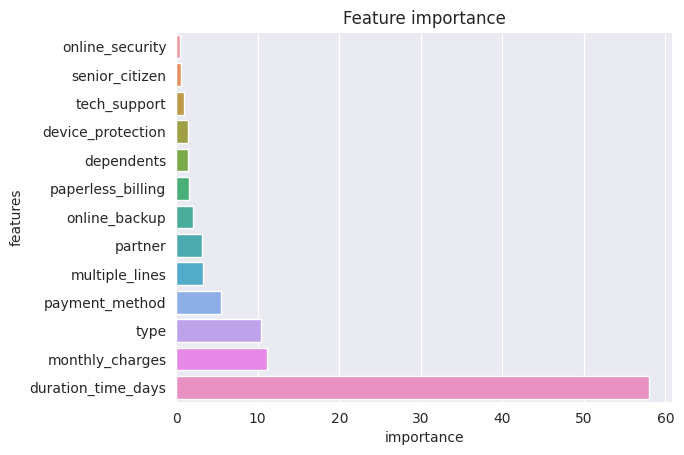

In [60]:
feature_importance_data = pd.DataFrame(model_best.feature_importances_,
                                       index=features_test.columns)

plot_features_importances(feature_importance_data)

**Вывод:**

Из графика видно, что `тип оплаты`, `ежемесяячные траты на услуги по договру` и `срок пользования услугами в днях` — являются самыми значимыми.


**Вывод:** 

Подводя итоги, сделаем выводы по каждому пункту:

1. Загрузка и изучение данных.

2. Подготовка данных

3. Исследовательский анализ данных.

5. Предобработка данных.

6. Подготовка данных к обучению.

7. Обучение модели.

8. Проверка модели

9. Анализ важности признаков.

10. Вывод.


**Обзор данных**

* подключены все необходимые библиотеки
* успешно загружены данные 
* получены общие данные о таблице
* все столбцы приведены к нижнему регистру
* изменены некорректные типы данных в столбцах
* выявлены неявные пропуски

**Подготовка данных**

* соединены таблицы
* добавлен целевой признак `is_clien`
* добавлен новый признак `duration_time_days`
* удалены незначащие столбцы

**Исследовательский анализ данных**

* построены распределения категориальных и количественных признаков
* определены тенденции

**Предобработка данныхх**

* удалены пропуски и заполнены пропущенные значения
* проведено исследование признаков на мультиколлинеарность
* удалены сильно коррелирующие признаки
* выявлен диссбаланс классов

**Подготовка данных к обучению**

* разделены данные на обучающую и тестовую выборки в соотношении 3:1
* произведена кодировка данных с помщью OrdinalEncoder
* признаки приведены к одному масштабу

**Обучение модели**

Были обучены следующие модели:

Простые модели:

* DecisionTreeClassifier
* RandomForestClassifier

Модели на основе градиентного бустинга:

* CatBoostClassifier

Лучше всех себя показала модель `CatBoostClassifier` с метрикой `roc-auc` - 0.90.

**Проверка модели**

Значение модели на тестовой выборке:

* `Accuracy`: 0.90
* `ROC-AUC`: 0.90

Проведен анализ матрицы ошибок, который показал, что:

* значение TrueNegative - 1469, т.е модель хорошо предсказывает пользователей, которые не уйдут.
* значение TruePositive - 122, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут. Правильных ответов - 122 из 139.
* Значение False Positive - 17, т.е модель не так сильно промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 17 из 139.
* значение FalseNegative - 153, т.е модель иногда предсказывает, что пользователи, которые не должны уйти, уйдут. Это не так страшно, ведь главная цель, как можно лучше определить пользоватлей, которые могут покинуть сервис.

**Анализ важности признаков**

Выявлены самые значащие признаки:

* `тип оплаты`
* `ежемесяячные траты на услуги по договру` 
* `срок пользования услугами в днях`

## Отчет

**Выделим ключевые шаги работы над проектом:**

1. Загрузка и изучение данных.

2. Подготовка данных

3. Исследовательский анализ данных.

4. Предобработка данных.

5. Подготовка данных к обучению.

6. Обучение модели.

7. Проверка модели.

8. Анализ важности признаков.

**Проанализируем соответствие фактической работы запланированным шагам:**

Данные были успешно:

    1. Загружены и изучены.
    2. Подготовлены к работе и исследованию.
    3. Исследованы наглядным образом.
    4. Предобработаны.
    5. Подготовленны к обучению.

Модели были успешно:

    1. Обучены с разными гиперпараметрами.
    2. Проанализированы на лучшее качество предсказаний.

Лучшая модель была успешно:

    1. Проверенная на тестовой выборке.
    2. Проранжированна по важности признаков.


**Рефлексия над сложностями и описание путей их решения:**

1. На этапе загрузки и изучения данных были следующие проблемы:
    * При попытке изменить тип данных в столбце `totalcharges` были найдены неявные пропуски, а точнее пустые строки, что не давало привести столбец к типу `float`. Следовательно, было принято решение использовать функцию `to_numeric` библиотеки *pandas* с параметром `errors = 'coerce'`, чтобы вместо шибки возвращалось значение Nan.

2. На этапе подготовки данных были следующие проблемы:
    * В данных отсутствовал целевой признак `клиент ушел? — да или нет`. Следовательно, было принято решение создать целевой признак с помощью столбца `end_date`, то есть  если дата имеет значения `2020-02-01` (дата выгрузки данных), то клиент не ушел, а если другая дата, то клиент покинул сервис. Изначально в столбце `end_date` были даты ухода и значения `No`, поэтому было принято решение заменить значения `No` — датой выгрузки (`2020-02-01`).

3. На этапе исследования данных проблем не было.

4. На этапе предобработки данных проблем не было.

5. На этапе подготовки данных к обучению были следующие проблем:

    * Необходимо было выбрать метод кодирования категориальных признаков. Для древесных и бустинговых моделей лучше всего подходит метод кодирования `OrdinalEncoder()`, так как он не создает дополнительных столбцов, поэтому было принято решение использовать его.

6. На этапе обучения модели проблем не было.
7. На этапе проверки модели проблем не было.
8. На этапе анализа важности признаков проблем не было.

**Итоговый список признаков для обучения и способы обработки:**

Итоговый список признаков:

* `senior_citizen` — наличие пенсионного статуса по возрасту,
* `partner` — наличие супруга(и),
* `dependents` — наличие иждивенцев,
* `type` — тип оплаты: ежемесячный, годовой и тд,
* `paperless_billing` — безбумажное выставление счета,
* `payment_method` — способ оплаты,
* `monthly_charges` — ежемесячные траты на услуги по договору,
* `online_security` — онлайн-безопасность
* `online_backup` — онлайн резервное копирование
* `device_protection` — защита устройства,
* `tech_support` — техническая поддержка
* `multiple_lines` — наличие возможности ведения параллельных линий во время звонка
* `duration_time_days` — срок пользования услугами в днях.

Целевой признак:

* `is_client` - остался ли клиент в сервисе.


Кодирование категориальны признаков производилось с помощью `OrdinalEncoder()`.

Стандартизация количественных признаков производилось с помощью `StandardScaler()`.

**Краткое описание предобработки данных:**

На этапе предобработки были выявлены следующие проблемы в данных:

1. Присутсвуют пропуски в столбцах:

* `online_security`
* `online_backup`
* `streaming_movies`
* `streaming_t_`
* `tech_support`
* `internet_service`
* `device_protection`
* `multiple_lines`
* `total_charges`

2. Присутствует мультиколлинеарность:

* столбцы `internet_service`,  `streaming_t_v`, `streaming_movies` сильно коррелируют с признаком `monthly_charges`,
* столбец `total_charges` сильно коррелирует со столбцом `duration_time_days`,
* присутствует дисбаланс классов целевого признака `is_client`.

Были приняты следующие решения:

1.
* Пропуски в первых 9-и столбцах говорят о том, что, либо данные некоторых клиентов не внесены в базу, либо у клиента попросту нет данных функций. Следовательно, было приянто решение заполнить пропуски отрицательными значениями,

* Пропусков в значениях столбца `total_charges` говорят о том, что пользователь еще не успел совершить покупки, поэтому было принято решение заполнить значением `0`.

2.
* так как столбцы `internet_service`,  `streaming_t_v`, `streaming_movies` сильно коррелируют с признаком `monthly_charges`, было принято решение удалить их,

* так как столбец `total_charges` сильно коррелирует со столбцом `duration_time_days`, было принято удалить столбец `total_charges`,

3.
* так как при обучении была выбрана метрика качества `ROC-AUC`, которая нечувствительна к дисбалансу классов, было принято решение не производить никаких манипуляций с целевой переменной.

**Сводная таблица исследованных моделей и их метрика на кросс-валидации:**

| **Модель**            | **ROC-AUC**   |
| --------------------- |:-------------:|
| DecisionTreeClassifier| 0.79 |
| RandomForestClassifier| 0.82 |
| CatBoostClassifier    | 0.90 |

**Лучшая модель:**

| **Модель**            | **Гиперпараметры**   | **ROC-AUC**   |
| --------------------- |:--------------------:|:-------------:|
| CatBoostClassifier    | 'depth': 5, 'learning_rate': 0.03 | 0.90

**Итоговые метрики лучшей модели на test:**

| **Модель**            | **Accuracy**   | **ROC-AUC**   |
| --------------------- |:--------------------:|:-------------:|
| CatBoostClassifier    | 0.90 | 0.89

**Матрица ошибок**


Количество записей: 1409



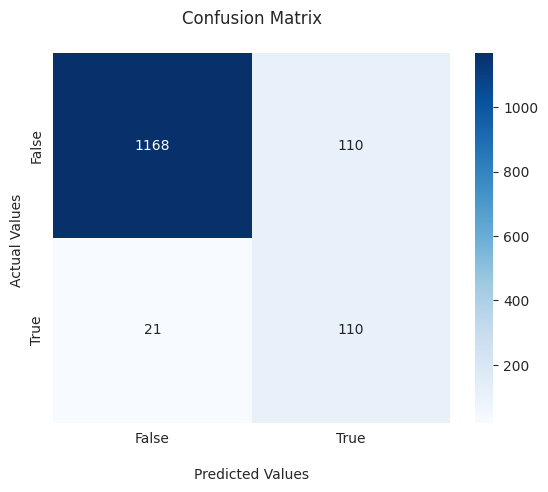

In [61]:
plot_conf_matr(model_best, features_test, target_test)

Из построенной матрицы ошибок можно сделать вывод:

* значение TrueNegative - 1469, т.е модель хорошо предсказывает пользователей, которые не уйдут.
* значение TruePositive - 122, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут. Правильных ответов - 122 из 139.
* Значение False Positive - 17, т.е модель не так сильно промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 17 из 139.
* значение FalseNegative - 153, т.е модель иногда предсказывает, что пользователи, которые не должны уйти, уйдут. Это не так страшно, ведь главная цель, как можно лучше определить пользоватлей, которые могут покинуть сервис.

**Важность признаков:**

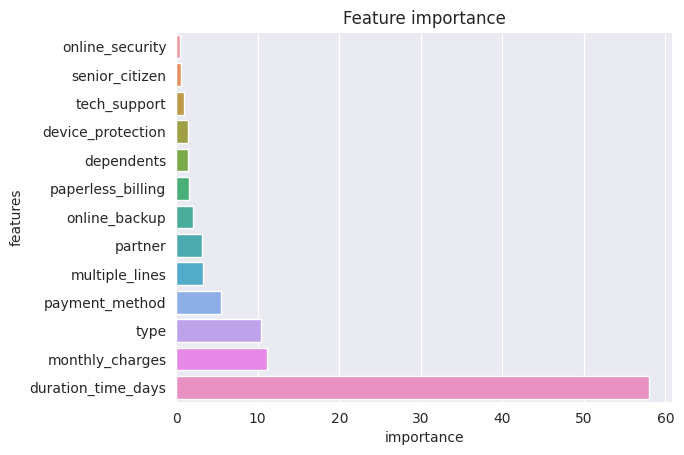

In [62]:
plot_features_importances(feature_importance_data)

Из графика видно, что `тип оплаты`, `ежемесяячные траты на услуги по договру` и `срок пользования услугами в днях` — являются самыми значимыми.